# 1. Intro

## 1.1 Project Purpose and Approach

### Purpose
The purpose of this project is to study whether an individual (a single person) is vulnerable to depression or not.  
This is a **classification** task.

### Metrics
- **Accuracy**: Used as the primary metric for scoring submissions.  
- **ROC_AUC**: Used for training the underlying models to mitigate overfitting issues, especially when using AutoGluon.

### Approach
1. Use AutoGluon to identify "the best base models".  
2. Select the top ten models based on performance.  
3. Conduct hyperparameter tuning on the best unique instances from those top models.


## 1.2 Data

### Overview
The dataset provided for this competition consists of a training set and a test set.  
It was generated using a deep learning model trained on the [original dataset](https://www.kaggle.com/datasets/sumansharmadataworld/depression-surveydataset-for-analysis).

### Target Variable
- **Depression** (binary)

### Numerical Features
- **Age**  
- **Academic Pressure**  
- **Work Pressure**  
- **CGPA** (Cumulative Grade Point Average)  
- **Study Satisfaction**  
- **Job Satisfaction**  
- **Work/Study Hours**  
- **Financial Stress**  

### Categorical Features
- **Name**  
- **Gender**  
- **Working Professional or Student**  
- **Profession**  
- **Sleep Duration**  
- **Dietary Habits**  
- **Degree**  
- **Have you ever had suicidal thoughts?**  
- **Family History of Mental Illness**


# 2. Loading the data, first insight

### 2.1 Importing required libraries, loading the data

In [3]:
# Data Manipulation
import numpy as np 
import pandas as pd 

# Data Visualization
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
#import plotly.offline as py
#import plotly.graph_objs as go
#import plotly.tools as tls


# Machine Learning
from    sklearn.ensemble import StackingClassifier
from    sklearn.linear_model import LogisticRegression
from    sklearn.metrics import make_scorer
from    sklearn.model_selection import cross_val_score
from   sklearn.model_selection import StratifiedKFold
from   sklearn.metrics import accuracy_score
from   xgboost import XGBClassifier
from   lightgbm import LGBMClassifier
from   catboost import CatBoostClassifier

import warnings
import optuna

# Set Options
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv", index_col = "id")
test = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv", index_col = "id")
original = pd.read_csv("/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv")

### 2.2 First observations

In [3]:
print(f"Shape of the train dataset: {train.shape}")
print(f"Shape of the test dataset: {test.shape}")
print(f"Shape of the original dataset: {original.shape}")

Shape of the train dataset: (140700, 19)
Shape of the test dataset: (93800, 18)
Shape of the original dataset: (2556, 19)


In [4]:
def explore_dataframe(df, name="DataFrame"):
    print("=" * 60)
    print(f"{name.upper()} DATAFRAME")
    print("=" * 60 + "\n")
    
    print("First 5 rows:")
    display(df.head())  
    print("\n")
    
    print("DataFrame Info:")
    df.info()  
    print("\n")
    
    print("Null values(percentage):")
    null_percent = (df.isnull().mean() * 100).sort_values(ascending=False)
    display(pd.DataFrame(null_percent, columns=["Null %"]))
    print("\n")
    
    print("Basic statistics:")
    display(df.describe().T) 
    print("\n")


In [5]:
explore_dataframe(train, name="train")


TRAIN DATAFRAME

First 5 rows:


,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0




DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       1127

,Null %
Study Satisfaction,80.172708
Academic Pressure,80.172708
CGPA,80.171997
Profession,26.034115
Work Pressure,19.842217
Job Satisfaction,19.836532
Dietary Habits,0.002843
Financial Stress,0.002843
Degree,0.001421
Family History of Mental Illness,0.000000




Basic statistics:


,count,mean,std,min,25%,50%,75%,max
Age,140700.0,40.388621,12.384099,18.00,29.00,42.00,51.00,60.0
Academic Pressure,27897.0,3.142273,1.380457,1.00,2.00,3.00,4.00,5.0
Work Pressure,112782.0,2.998998,1.405771,1.00,2.00,3.00,4.00,5.0
CGPA,27898.0,7.658636,1.464466,5.03,6.29,7.77,8.92,10.0
Study Satisfaction,27897.0,2.944940,1.360197,1.00,2.00,3.00,4.00,5.0
Job Satisfaction,112790.0,2.974404,1.416078,1.00,2.00,3.00,4.00,5.0
Work/Study Hours,140700.0,6.252679,3.853615,0.00,3.00,6.00,10.00,12.0
Financial Stress,140696.0,2.988983,1.413633,1.00,2.00,3.00,4.00,5.0
Depression,140700.0,0.181713,0.385609,0.00,0.00,0.00,0.00,1.0


In [6]:
explore_dataframe(test, name="test")


TEST DATAFRAME

First 5 rows:


,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,,
140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No




DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 93800 entries, 140700 to 234499
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   93800 non-null  object 
 1   Gender                                 93800 non-null  object 
 2   Age                                    93800 non-null  float64
 3   City                                   93800 non-null  object 
 4   Working Professional or Student        93800 non-null  object 
 5   Profession                             69168 non-null  object 
 6   Academic Pressure                      18767 non-null  float64
 7   Work Pressure                          75022 non-null  float64
 8   CGPA                                   18766 non-null  float64
 9   Study Satisfaction                     18767 non-null  float64
 10  Job Satisfaction                       75026 non-nu

,Null %
CGPA,79.993603
Study Satisfaction,79.992537
Academic Pressure,79.992537
Profession,26.260128
Work Pressure,20.019190
Job Satisfaction,20.014925
Dietary Habits,0.005330
Degree,0.002132
Financial Stress,0.000000
Work/Study Hours,0.000000




Basic statistics:


,count,mean,std,min,25%,50%,75%,max
Age,93800.0,40.321685,12.393480,18.00,29.00,42.0,51.00,60.0
Academic Pressure,18767.0,3.158576,1.386666,1.00,2.00,3.0,4.00,5.0
Work Pressure,75022.0,3.011797,1.403563,1.00,2.00,3.0,4.00,5.0
CGPA,18766.0,7.674016,1.465056,5.03,6.33,7.8,8.94,10.0
Study Satisfaction,18767.0,2.939522,1.374242,1.00,2.00,3.0,4.00,5.0
Job Satisfaction,75026.0,2.960920,1.410710,1.00,2.00,3.0,4.00,5.0
Work/Study Hours,93800.0,6.247335,3.858191,0.00,3.00,6.0,10.00,12.0
Financial Stress,93800.0,2.978763,1.414604,1.00,2.00,3.0,4.00,5.0


In [7]:
explore_dataframe(original, name="Original dataset")


ORIGINAL DATASET DATAFRAME



First 5 rows:


,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No




DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   2556 non-null   object 
 1   Gender                                 2556 non-null   object 
 2   Age                                    2556 non-null   int64  
 3   City                                   2556 non-null   object 
 4   Working Professional or Student        2556 non-null   object 
 5   Profession                             1883 non-null   object 
 6   Academic Pressure                      502 non-null    float64
 7   Work Pressure                          2054 non-null   float64
 8   CGPA                                   502 non-null    float64
 9   Study Satisfaction                     502 non-null    float64
 10  Job Satisfaction                       2054 non-null  

,Null %
Study Satisfaction,80.359937
Academic Pressure,80.359937
CGPA,80.359937
Profession,26.330203
Work Pressure,19.640063
Job Satisfaction,19.640063
Dietary Habits,0.000000
Family History of Mental Illness,0.000000
Financial Stress,0.000000
Work/Study Hours,0.000000




Basic statistics:


,count,mean,std,min,25%,50%,75%,max
Age,2556.0,39.043036,12.260596,18.00,28.00,39.000,50.000,60.0
Academic Pressure,502.0,3.003984,1.390007,1.00,2.00,3.000,4.000,5.0
Work Pressure,2054.0,3.021908,1.417312,1.00,2.00,3.000,4.000,5.0
CGPA,502.0,7.567809,1.465367,5.03,6.21,7.605,8.825,10.0
Study Satisfaction,502.0,3.075697,1.373490,1.00,2.00,3.000,4.000,5.0
Job Satisfaction,2054.0,3.015093,1.418432,1.00,2.00,3.000,4.000,5.0
Work/Study Hours,2556.0,6.023865,3.771743,0.00,3.00,6.000,9.000,12.0
Financial Stress,2556.0,2.968701,1.415527,1.00,2.00,3.000,4.000,5.0


### Training Dataset Overview

- **Size**: 140,700 rows, 19 columns  
- **Column Breakdown**:  
  - 8 numeric columns  
  - 10 categorical columns  
  - 1 target variable column  
- **Missing Values**:  
  - The dataset contains a significant number of missing values, which will require imputation.  
- **Outliers**:  
  - Statistical analysis indicates no significant outliers, so no outlier handling is needed.  
- **Categorical Features with Many Unique Values**:  
  - Some categorical columns have a high cardinality, which will require special handling in subsequent steps.  


# 3. EDA

### 3.1 Numerical features

In [8]:
def plot_numeric_distribution(df, target="Depression"):
    numeric_cols = df.select_dtypes(include = ['number']).columns.tolist()
    if target in numeric_cols:
        numeric_cols.remove(target)
    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        sns.histplot(data=df, x=col, hue=target, kde=True, ax=axes[0])
        axes[0].set_title(f"{col}")

        sns.boxplot(data=df, x=target, y=col, ax=axes[1])
        axes[1].set_title(f"{col}")

        plt.tight_layout()
        plt.show()


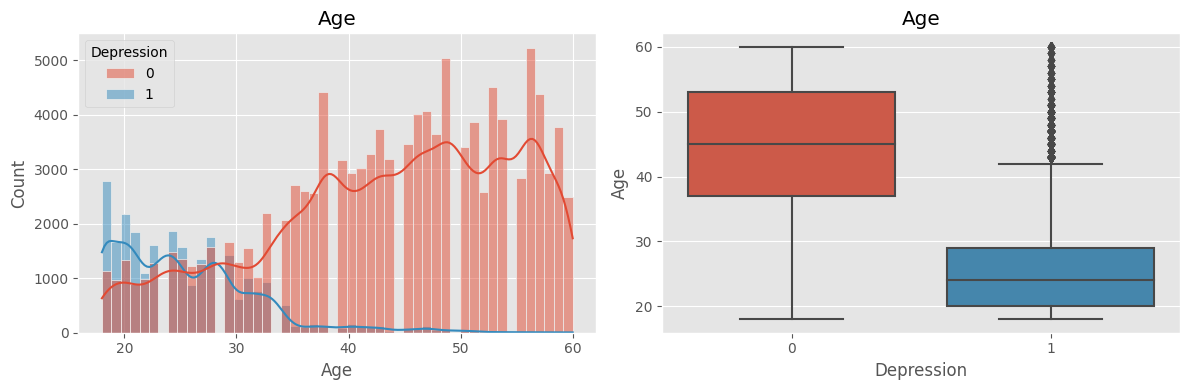

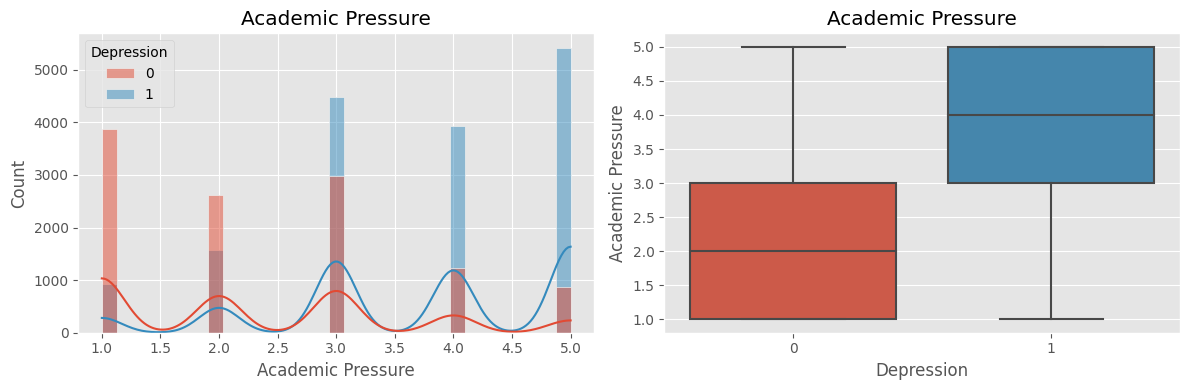

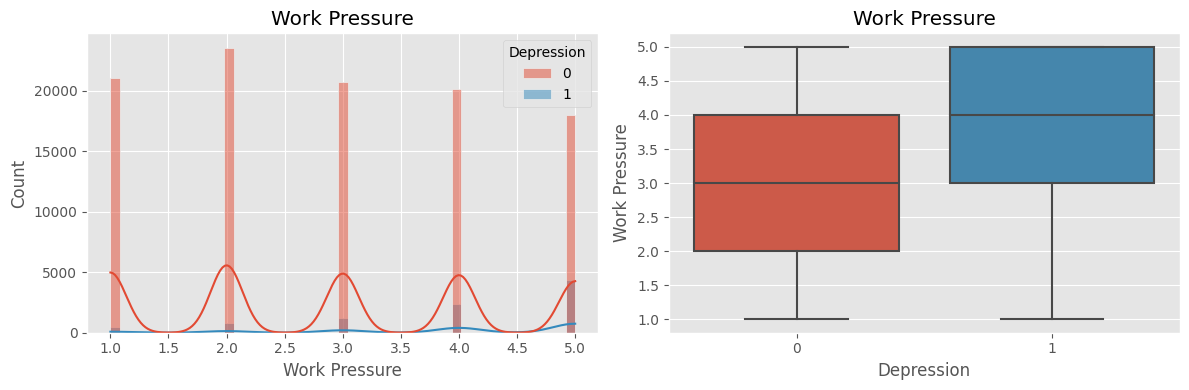

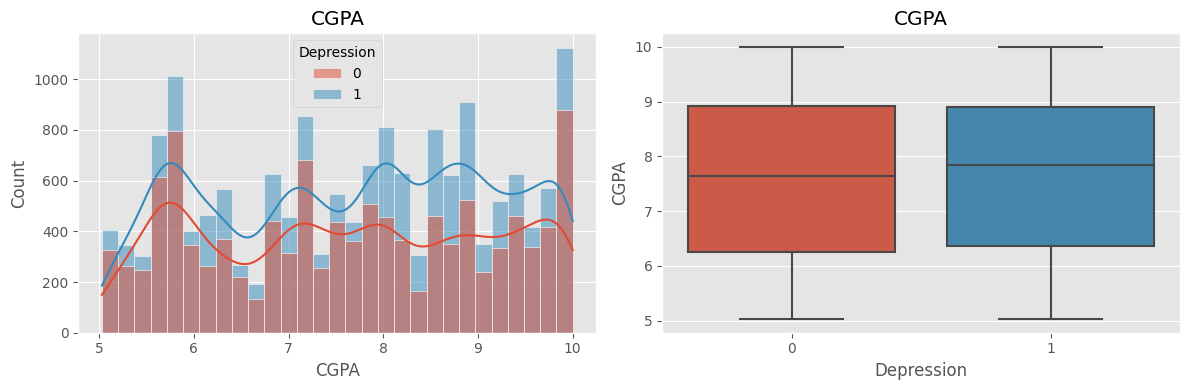

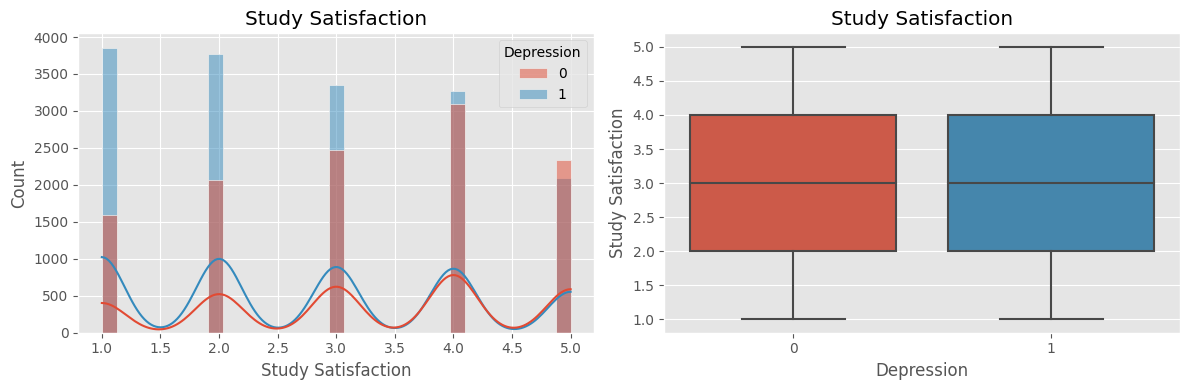

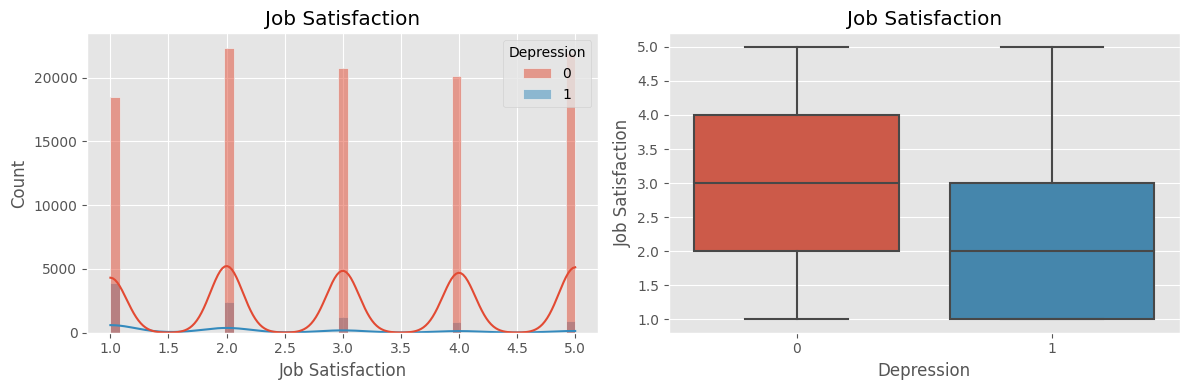

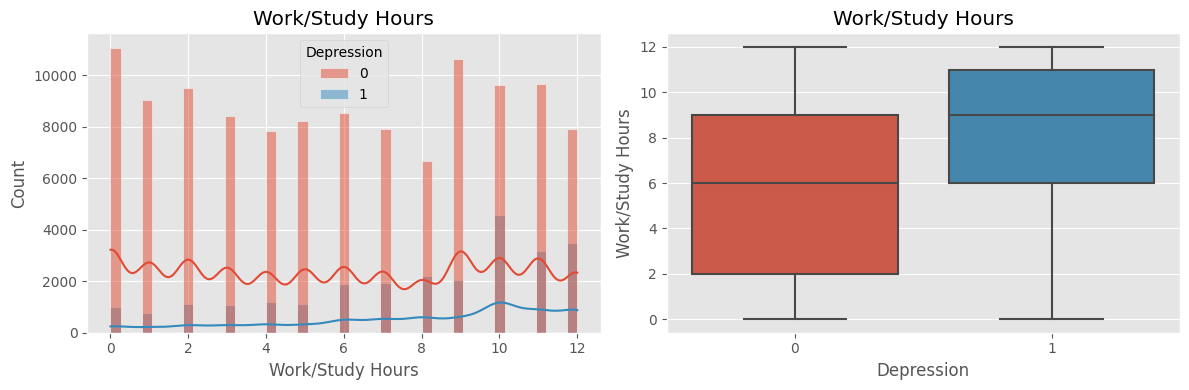

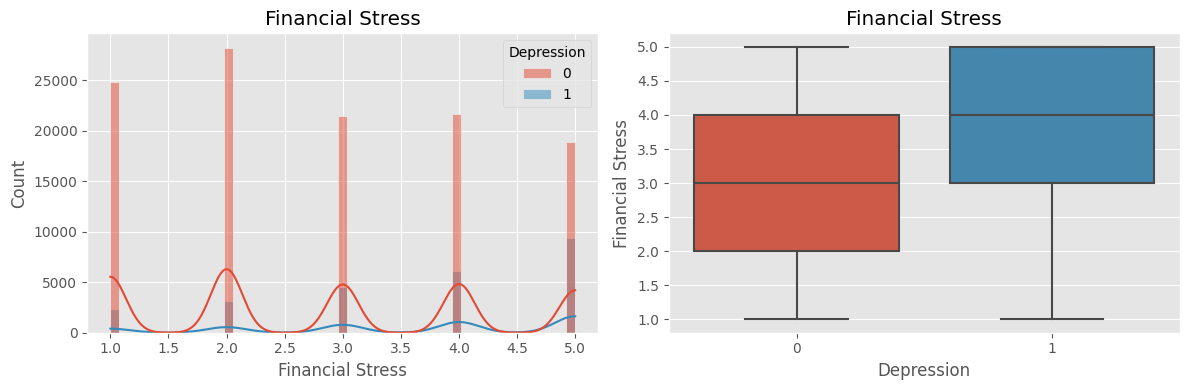

In [9]:
plot_numeric_distribution(train)

#### Observations

1. **Age**  
   - Individuals with depression (1) tend to be younger on average than those without depression (0).  
   - The box plot for the depressed group is shifted lower, indicating a lower median age.

2. **Academic Pressure**  
   - The depressed group exhibits higher median academic pressure.  
   - Distribution curves suggest that those with depression are more likely to report elevated academic stress.

3. **Work Pressure**  
   - Similar to academic pressure, the depressed group reports higher work pressure on average.  
   - The box plot reveals a higher median and a broader range for individuals with depression.

4. **CGPA**  
   - CGPA alone may not strongly distinguish between the groups.

5. **Study Satisfaction**  
   - Individuals without depression show a higher median study satisfaction score.  
   - Study Satisfaction alone may not strongly distinguish between the groups.

6. **Job Satisfaction**  
   - Depressed individuals report lower job satisfaction compared to those without depression.  
   - The box plot indicates a noticeable drop in median job satisfaction for the depressed group.

7. **Work/Study Hours**  
   - Depressed individuals report spending more hours working or studying.  
   - The distribution is skewed toward higher hour commitments for the depressed group.

8. **Financial Stress**  
   - Financial stress levels are higher in the depressed group.  
   - A pronounced difference in medians suggests financial stress may be a significant factor.
---

In summary, **younger individuals** with **more academic/work pressures**, **more work/study hours**, **higher financial stress**, and **lower satisfaction (study and job)** appear to be more prone to depression.

### 3.2 Categorical features

In [10]:
def plot_categorical_distribution(df, target="Depression"):
    cat_cols = df.select_dtypes(exclude = ["number"]).columns.tolist()
    if target in cat_cols:
        cat_cols.remove(target)
    for col in cat_cols:
        percentage_df = (
            df.groupby(col)[target]
            .mean()
            .reset_index()
            .reset_index()
            .rename(columns = {target: 'Depression_pct'})
       )
        percentage_df['Depression_pct'] = percentage_df['Depression_pct'] * 100
        percentage_df.sort_values(by = 'Depression_pct', ascending = False, inplace = True)
        
        
        plt.figure(figsize = (8, 4))
        sns.barplot(
            data = percentage_df,
            x = col,
            y = 'Depression_pct',
            palette = 'Set2'
        )
        
        plt.title(f'Percentage of Depression=1 by {col}')
        plt.ylabel('Depression (%)')
        plt.xlabel(col)
        plt.xticks(rotation = 45, ha = 'right')
        plt.tight_layout()
        plt.show()

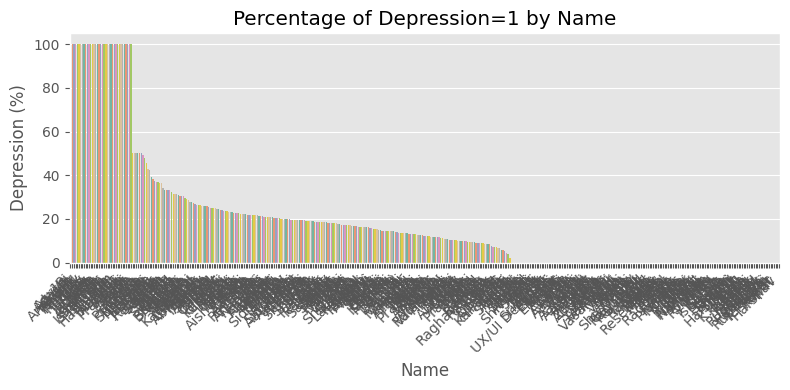

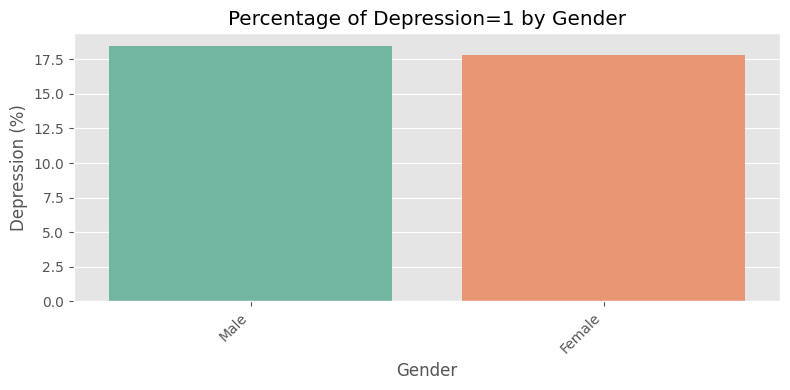

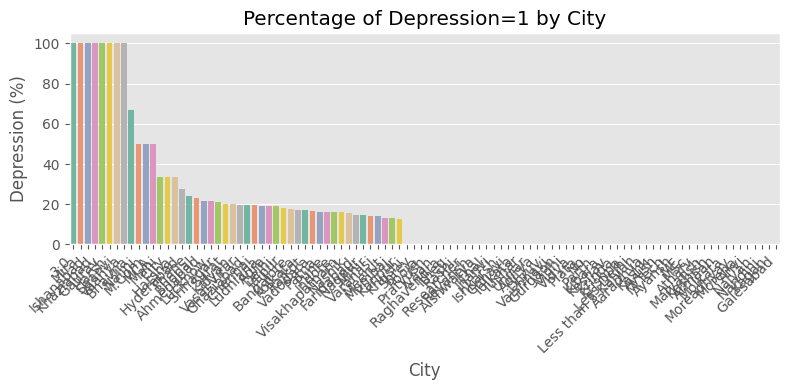

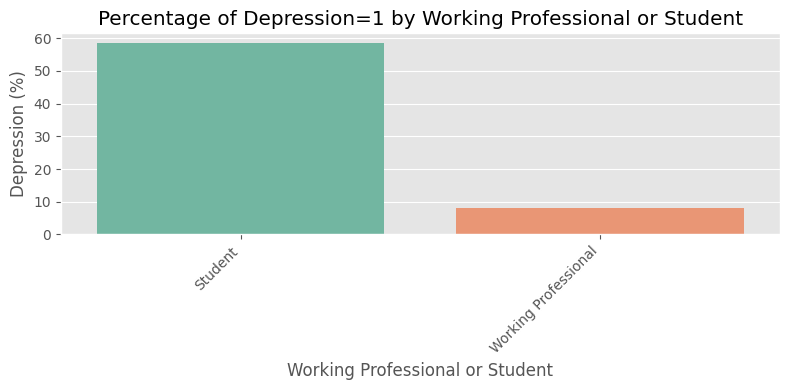

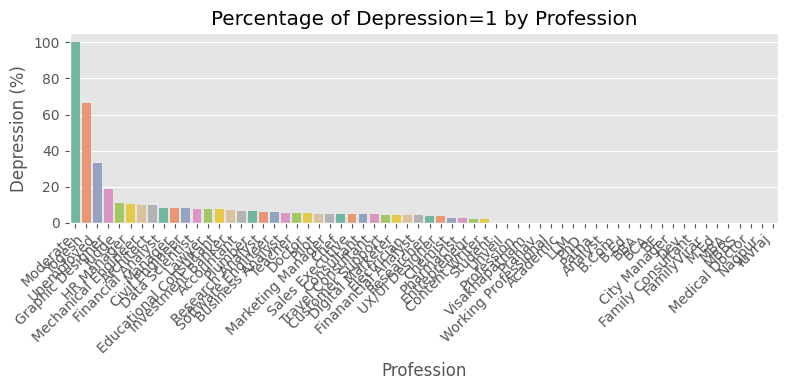

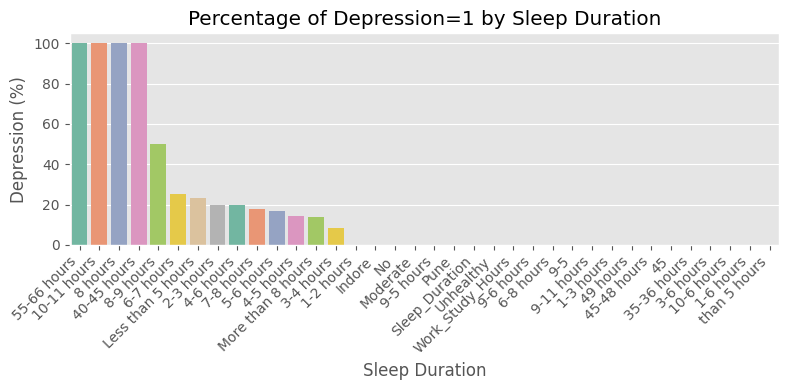

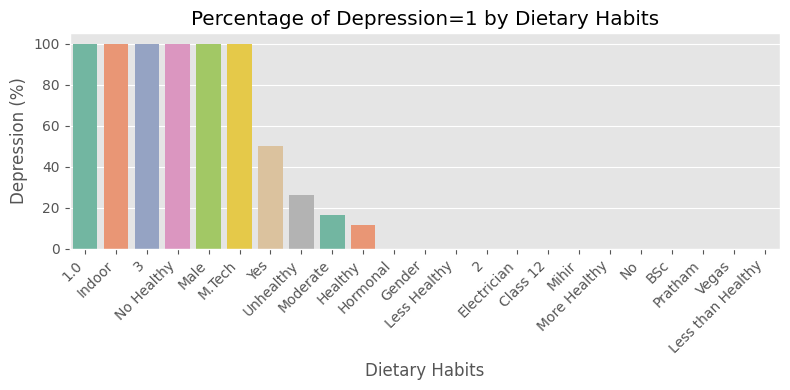

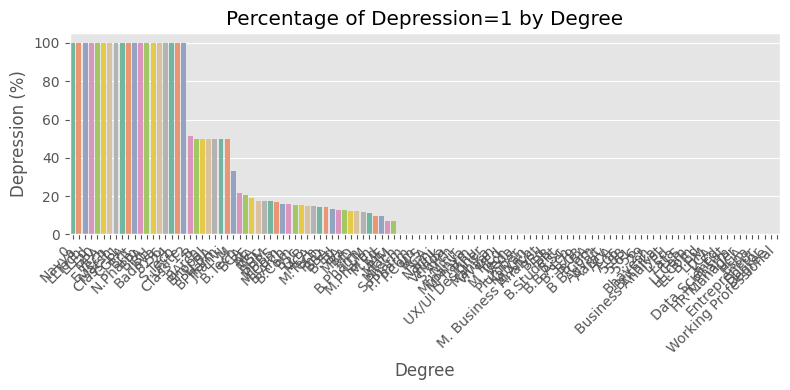

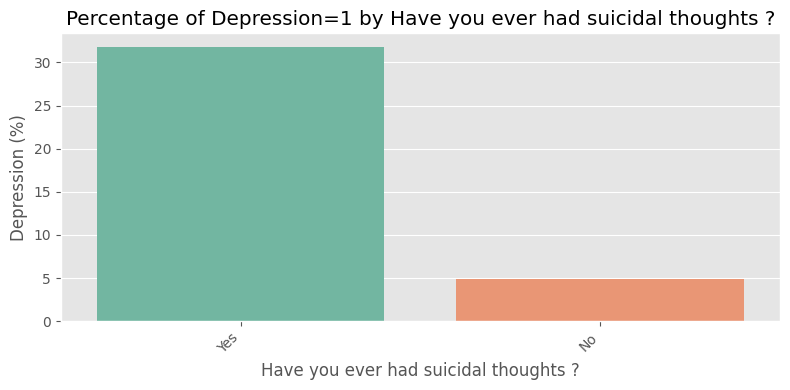

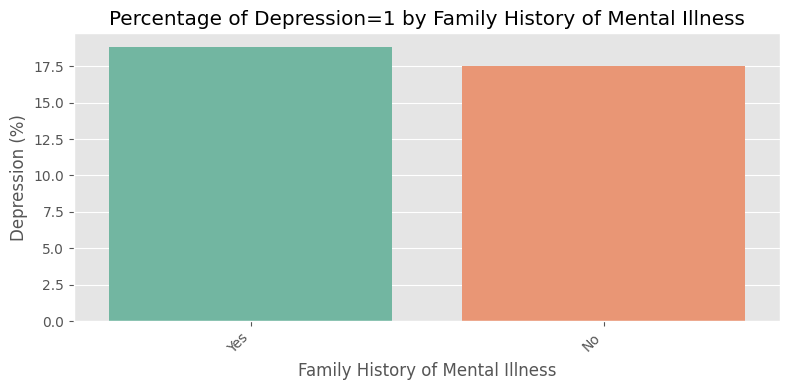

In [11]:
plot_categorical_distribution(train)

#### Observations
   - Some profession seem to have higher depression rate
   - Some cities seem to have higher depression rate
   - Some Names also, but this is probably a coincidence

### 3.3 Target variable

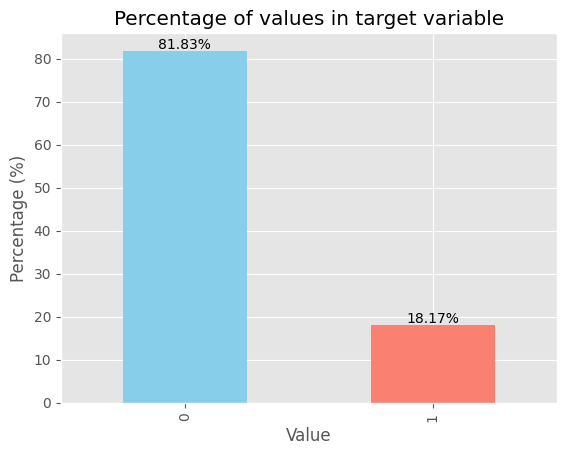

In [12]:
depression_counts = train['Depression'].value_counts(normalize=True) * 100


depression_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Percentage of values in target variable')
plt.xlabel('Value')
plt.ylabel('Percentage (%)')

for index, value in enumerate(depression_counts):
    plt.text(index, value + 0.5, f"{value:.2f}%", ha='center')

plt.show()


#### Observation

- The target variable (**Depression**) is imbalanced, with approximately **82%** of instances labeled as “0” (no depression) and only **18%** labeled as “1” (depression).  
- Because of this imbalance, a simple model that always predicts “0” could achieve around 82% accuracy.  
- When optimizing and evaluating the model using **accuracy score**, it’s important to account for this imbalance to avoid overly optimistic results.  


# 4. Data cleaning

### Observations (Categorical Data)

- **Data Quality**:  
  - Some columns contain incorrect or inconsistent values (inherent to the synthetic nature of the dataset).  
  - We plan to reference the original dataset to filter out or correct these anomalies.

- **Column Consolidation**:  
  - **Study Satisfaction** and **Job Satisfaction**  
    - Respondents typically answer only one of these, depending on whether they are students or working professionals.  
    - We will merge these into a single “Satisfaction” column.  
  - **Work Pressure** and **Academic Pressure**  
    - Similarly, each respondent only provides one relevant form of pressure.  
    - We will combine these into a single “Pressure” column.

- **Sleep Duration**:  
  - The “Sleep Duration” column has relatively few unique values.  
  - We will perform a manual conversion (e.g., mapping text descriptions to numeric ranges) for simplicity and consistency.


In [13]:
train = pd.concat([train, original]).reset_index()
train=train.drop('index', axis = 1)

In [14]:
train.shape

(143256, 19)

In [2]:
import re

def clean_data(is_catboost=False):
    train = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv", index_col='id')
    test = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv", index_col='id')
    def extract_hours(string):
        string = str(string).lower()
        numbers = re.findall(r'\d+', string)
        numbers = [float(num) for num in numbers]

        if not numbers:
            return None

        if 'to' in string or '-' in string:
            return sum(numbers) / len(numbers)
        elif 'less' in string:
            return numbers[0] - 0.5
        elif 'more' in string:
            return numbers[0] + 0.5
        else:
            return numbers[0] / 7 if numbers[0] > 24 else numbers[0]

    train['Sleep Duration'] = train['Sleep Duration'].apply(extract_hours)
    test['Sleep Duration']  = test['Sleep Duration'].apply(extract_hours)
    
    def replace_rare_values(df, feature, threshold=20):
        counts = df[feature].value_counts()
        rare_values = counts[counts < threshold].index
        return df[feature].replace(rare_values, 'missing')

    cat_feats = train.select_dtypes(include='object').columns.tolist()
    for feat in cat_feats:
        train[feat] = replace_rare_values(train, feat)
        if feat in test.columns:
            test[feat] = replace_rare_values(test, feat)

    train['Satisfaction'] = train['Study Satisfaction'].fillna(train['Job Satisfaction'])
    test['Satisfaction']  = test['Study Satisfaction'].fillna(test['Job Satisfaction'])

    train['Pressure'] = train['Academic Pressure'].fillna(train['Work Pressure'])
    test['Pressure']  = test['Academic Pressure'].fillna(test['Work Pressure'])

    train.loc[train['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
    test.loc[test['Working Professional or Student'] == 'Student', 'Profession']   = 'Student'

    drop_cols = [
        'Study Satisfaction', 'Job Satisfaction',
        'Academic Pressure', 'Work Pressure',
        'Working Professional or Student'
    ]
    train.drop(columns=drop_cols, inplace=True)
    test.drop(columns=drop_cols, inplace=True)

    if is_catboost:
        categorical_columns = list(test.columns)
    else:
        categorical_columns = test.select_dtypes(include='object').columns.tolist()

    train[categorical_columns] = train[categorical_columns].astype(str).astype('category')
    test[categorical_columns]  = test[categorical_columns].astype(str).astype('category')

    X_train = train.drop(columns=['Depression'])
    y_train = train['Depression']
    X_test  = test

    # Return results
    if is_catboost:
        return X_train, y_train, X_test, categorical_columns
    else:
        return X_train, y_train, X_test


# 5. Hyperparameter Tuning

<div align="center">
  <img src="img/sub_autogluon.png" alt="Wynik trenowania AutoGluon" width="300" />
  <p>Submission file based on AutoGluon</p>
</div>


### Model Selection & Ensembles
Based on our analysis(baseline.ipynb), the **best single models** are:
- **XGBoost**
- **LightGBM**
- **CatBoost**

We will tune the hyperparameters for each of these models. After tuning, we plan to generate and compare the following final outputs:

1. **Pure XGBoost**  
2. **Pure LightGBM**  
3. **Pure CatBoost**  
4. **Ensemble of Two Models** (XGboost + CatBoost)
4. **Ensemble of All Three Models** (XGBoost + LightGBM + CatBoost)

We will use the results obtained from AutoGluon (describing specific models) to see in which range it is best to look for hyperparameters + to se upper range in some case we'll use [this notebook on kaggle](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning), and simmilar notebooks with *LightGBM* and *CatBoost*

In [33]:
def create_model(trial, model_type):
    is_catboost = False
    
    if model_type == 'xgb':
        params = {
            "verbosity": 0,
            "objective": "binary:logistic",
            "reg_lambda": trial.suggest_float("reg_lambda", 0.3, 50, log=True),
            "gamma": trial.suggest_float("gamma", 0.3, 7, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10, log=True),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_child_weight": trial.suggest_int("min_child_weight", 12, 45),
            "subsample": trial.suggest_float("subsample", 0.8, 1.0),
            "n_estimators": trial.suggest_int("n_estimators", 300, 4500),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 1.5),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.95),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.15, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.3, 1.0),
            "max_bins": trial.suggest_int("max_bins", 5000, 30000),
            "max_leaves": trial.suggest_int("max_leaves", 10, 80),
            "n_jobs": -1,
            "enable_categorical": True
        }
        model = XGBClassifier(**params)
        
    elif model_type == 'lgbm':
        params = {"objective": "binary",
              "verbose": -1,
              "n_jobs": -1,
              "random_state": 42,
              "num_leaves": trial.suggest_int("num_leaves", 10, 200),
              "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
              "max_depth": trial.suggest_int("max_depth", 2, 10),
              "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
              "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
              "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
              "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
              "subsample": trial.suggest_float("subsample", 0.25, 1.0),
              "colsample_bytree": trial.suggest_float("colsample_bytree", 0.25, 1.0)
            }
        
        model = LGBMClassifier(**params)

    elif model_type == 'catboost':
        is_catboost = True
        params = {
            "verbose": False,
            "random_seed": 42,
            "depth": trial.suggest_int("depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "iterations": trial.suggest_int("iterations", 10, 3000),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10, log=True),
            "subsample": trial.suggest_float("subsample", 0.25, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0)
        }
        model = CatBoostClassifier(**params)
        
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")
    
    return model, is_catboost


def objective(trial, model, is_catboost):
    if is_catboost:
        X, y, X_test, cat_features = clean_data(is_catboost=True)
    else:
        X, y, X_test = clean_data()

    skf = StratifiedKFold(
        n_splits=10,
        random_state=42,
        shuffle=True
    )

    accuracy_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


        if is_catboost:
            model.fit(X_train, y_train, cat_features=cat_features)
        else:
            model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_val)[:, 1]
        y_pred = (y_proba > 0.5).astype(int)
        
        fold_accuracy = accuracy_score(y_val, y_pred)
        accuracy_scores.append(fold_accuracy)

    # Compute mean accuracy across folds
    mean_accuracy_score = np.mean(accuracy_scores)
    print(f"Mean accuracy score: {mean_accuracy_score:.5f}")

    return mean_accuracy_score


def objective_wrapper(trial, model_type):
    model, is_catboost = create_model(trial, model_type)
    return objective(trial, model, is_catboost)


In [17]:
run = 1

if run == 1:
    study_xgb = optuna.create_study(sampler=optuna.samplers.TPESampler(n_startup_trials=20, multivariate=True, seed=42), direction="maximize")
    study_xgb.optimize(lambda trial: objective_wrapper(trial, "xgb"), n_trials=50)
    print('Best value:', study_xgb.best_value)
    print('Best trial:', study_xgb.best_trial.params) 

[I 2025-01-21 16:50:27,215] A new study created in memory with name: no-name-a69b8e5b-a9be-493b-bbb7-a039419be265


[I 2025-01-21 16:52:50,036] Trial 0 finished with value: 0.9398009950248756 and parameters: {'reg_lambda': 2.0384156710475896, 'gamma': 5.99344266828314, 'reg_alpha': 2.9106359131330697, 'learning_rate': 0.07661100707771368, 'max_depth': 5, 'min_child_weight': 17, 'subsample': 0.8116167224336399, 'n_estimators': 3938, 'scale_pos_weight': 1.1011150117432087, 'colsample_bytree': 0.7602471755674295, 'colsample_bylevel': 0.16749682015143208, 'colsample_bynode': 0.978936896513396, 'max_bins': 25811, 'max_leaves': 25}. Best is trial 0 with value: 0.9398009950248756.


Mean accuracy score: 0.93980


[I 2025-01-21 16:55:08,122] Trial 1 finished with value: 0.9394740582800283 and parameters: {'reg_lambda': 0.7605168325586886, 'gamma': 0.5345820431474382, 'reg_alpha': 0.4059611610484306, 'learning_rate': 0.05958389350068958, 'max_depth': 10, 'min_child_weight': 21, 'subsample': 0.9223705789444759, 'n_estimators': 886, 'scale_pos_weight': 0.7921446485352182, 'colsample_bytree': 0.5381351981408995, 'colsample_bylevel': 0.5376594865844805, 'colsample_bynode': 0.8496231729751094, 'max_bins': 9992, 'max_leaves': 46}. Best is trial 0 with value: 0.9398009950248756.


Mean accuracy score: 0.93947


[I 2025-01-21 16:59:27,207] Trial 2 finished with value: 0.9394953802416488 and parameters: {'reg_lambda': 6.214079767384784, 'gamma': 0.3472676602735394, 'reg_alpha': 1.6409286730647923, 'learning_rate': 0.0178601378893971, 'max_depth': 4, 'min_child_weight': 44, 'subsample': 0.9931264066149119, 'n_estimators': 3696, 'scale_pos_weight': 0.8046137691733707, 'colsample_bytree': 0.3634868741041495, 'colsample_bylevel': 0.7315980725353334, 'colsample_bynode': 0.6081067456177209, 'max_bins': 8051, 'max_leaves': 45}. Best is trial 0 with value: 0.9398009950248756.


Mean accuracy score: 0.93950


[I 2025-01-21 17:00:40,368] Trial 3 finished with value: 0.9389339019189767 and parameters: {'reg_lambda': 0.35770692453820413, 'gamma': 5.260783812038974, 'reg_alpha': 0.3292759134423616, 'learning_rate': 0.09519754482692679, 'max_depth': 8, 'min_child_weight': 29, 'subsample': 0.9093420558686559, 'n_estimators': 1076, 'scale_pos_weight': 1.4695846277645586, 'colsample_bytree': 0.8038363351847244, 'colsample_bylevel': 0.9485741003295608, 'colsample_bynode': 0.9263791452993542, 'max_bins': 19948, 'max_leaves': 75}. Best is trial 0 with value: 0.9398009950248756.


Mean accuracy score: 0.93893


[I 2025-01-21 17:03:14,927] Trial 4 finished with value: 0.9394598436389481 and parameters: {'reg_lambda': 0.47177857009218327, 'gamma': 0.5561875470134457, 'reg_alpha': 0.12315571723666023, 'learning_rate': 0.03023795012558475, 'max_depth': 9, 'min_child_weight': 21, 'subsample': 0.9657475018303858, 'n_estimators': 1798, 'scale_pos_weight': 0.7809345096873808, 'colsample_bytree': 0.6527524540528614, 'colsample_bylevel': 0.2697855912285482, 'colsample_bynode': 0.8615378865278278, 'max_bins': 6863, 'max_leaves': 80}. Best is trial 0 with value: 0.9398009950248756.


Mean accuracy score: 0.93946


[I 2025-01-21 17:04:10,950] Trial 5 finished with value: 0.9398081023454157 and parameters: {'reg_lambda': 15.593095178364553, 'gamma': 0.5609959086237044, 'reg_alpha': 0.1025756397418565, 'learning_rate': 0.1601531217136121, 'max_depth': 15, 'min_child_weight': 36, 'subsample': 0.9542540693371891, 'n_estimators': 611, 'scale_pos_weight': 0.8584657285442726, 'colsample_bytree': 0.3753148886913343, 'colsample_bylevel': 0.8836379119942545, 'colsample_bynode': 0.7363086887792905, 'max_bins': 13272, 'max_leaves': 14}. Best is trial 5 with value: 0.9398081023454157.


Mean accuracy score: 0.93981


[I 2025-01-21 17:10:09,353] Trial 6 finished with value: 0.9376759061833688 and parameters: {'reg_lambda': 1.4725733528468332, 'gamma': 0.8355346985314328, 'reg_alpha': 2.878805718308924, 'learning_rate': 0.0874479618932312, 'max_depth': 18, 'min_child_weight': 28, 'subsample': 0.8239188491876603, 'n_estimators': 3296, 'scale_pos_weight': 1.2607850486168974, 'colsample_bytree': 0.6648301784201724, 'colsample_bylevel': 0.8053221029613769, 'colsample_bynode': 0.6456569174550735, 'max_bins': 18068, 'max_leaves': 40}. Best is trial 5 with value: 0.9398081023454157.


Mean accuracy score: 0.93768


[I 2025-01-21 17:11:39,876] Trial 7 finished with value: 0.9398294243070362 and parameters: {'reg_lambda': 0.3416635977150352, 'gamma': 0.421419106704215, 'reg_alpha': 0.11557352816269865, 'learning_rate': 0.08710745900492396, 'max_depth': 8, 'min_child_weight': 29, 'subsample': 0.9815132947852186, 'n_estimators': 1347, 'scale_pos_weight': 0.9103829230356297, 'colsample_bytree': 0.7911082400529816, 'colsample_bylevel': 0.3444784406678791, 'colsample_bynode': 0.35388593688015507, 'max_bins': 12244, 'max_leaves': 21}. Best is trial 7 with value: 0.9398294243070362.


Mean accuracy score: 0.93983


[I 2025-01-21 17:13:03,832] Trial 8 finished with value: 0.9382942430703626 and parameters: {'reg_lambda': 34.8954514370143, 'gamma': 3.824821515379975, 'reg_alpha': 1.8484491720988625, 'learning_rate': 0.1937550186412042, 'max_depth': 17, 'min_child_weight': 18, 'subsample': 0.9785117996979955, 'n_estimators': 2565, 'scale_pos_weight': 1.3074401551640626, 'colsample_bytree': 0.8824593449502705, 'colsample_bylevel': 0.4203029537260843, 'colsample_bynode': 0.37703634716937373, 'max_bins': 10698, 'max_leaves': 40}. Best is trial 7 with value: 0.9398294243070362.


Mean accuracy score: 0.93829


[I 2025-01-21 17:14:58,398] Trial 9 finished with value: 0.9392324093816631 and parameters: {'reg_lambda': 19.70726423070606, 'gamma': 4.514199112109318, 'reg_alpha': 0.10325337616482036, 'learning_rate': 0.05681142678077596, 'max_depth': 10, 'min_child_weight': 19, 'subsample': 0.8239730734667366, 'n_estimators': 1718, 'scale_pos_weight': 1.4429097039125192, 'colsample_bytree': 0.5100819058134909, 'colsample_bylevel': 0.5909720284818611, 'colsample_bynode': 0.7921132712266244, 'max_bins': 14091, 'max_leaves': 78}. Best is trial 7 with value: 0.9398294243070362.


Mean accuracy score: 0.93923


[I 2025-01-21 17:18:38,659] Trial 10 finished with value: 0.9373205401563609 and parameters: {'reg_lambda': 41.26041326486826, 'gamma': 0.6630611619546323, 'reg_alpha': 0.9874088417386248, 'learning_rate': 0.027824908605603306, 'max_depth': 8, 'min_child_weight': 13, 'subsample': 0.9219128667959794, 'n_estimators': 2411, 'scale_pos_weight': 0.5514787512499894, 'colsample_bytree': 0.48112020175379744, 'colsample_bylevel': 0.9220260030716556, 'colsample_bynode': 0.46769332346688064, 'max_bins': 8622, 'max_leaves': 44}. Best is trial 7 with value: 0.9398294243070362.


Mean accuracy score: 0.93732


[I 2025-01-21 17:21:10,692] Trial 11 finished with value: 0.939680170575693 and parameters: {'reg_lambda': 46.46088560312135, 'gamma': 0.643053708129097, 'reg_alpha': 2.2093834415066285, 'learning_rate': 0.1333535316674426, 'max_depth': 7, 'min_child_weight': 36, 'subsample': 0.8735566265438507, 'n_estimators': 2956, 'scale_pos_weight': 1.1335297107608948, 'colsample_bytree': 0.648253544648593, 'colsample_bylevel': 0.22674630454624706, 'colsample_bynode': 0.8847117469124666, 'max_bins': 13019, 'max_leaves': 23}. Best is trial 7 with value: 0.9398294243070362.


Mean accuracy score: 0.93968


[I 2025-01-21 17:23:24,941] Trial 12 finished with value: 0.9393887704335466 and parameters: {'reg_lambda': 0.3695876512142488, 'gamma': 1.9295191073551166, 'reg_alpha': 2.2653156413948867, 'learning_rate': 0.01058040360169664, 'max_depth': 12, 'min_child_weight': 19, 'subsample': 0.92903455808189, 'n_estimators': 1032, 'scale_pos_weight': 1.190937738102466, 'colsample_bytree': 0.5513779750953492, 'colsample_bylevel': 0.9462204904262244, 'colsample_bynode': 0.39626466090219525, 'max_bins': 13526, 'max_leaves': 18}. Best is trial 7 with value: 0.9398294243070362.


Mean accuracy score: 0.93939


[I 2025-01-21 17:24:20,211] Trial 13 finished with value: 0.9367306325515281 and parameters: {'reg_lambda': 34.013444471674475, 'gamma': 4.7566491926019525, 'reg_alpha': 0.3280071082578535, 'learning_rate': 0.09437923703573488, 'max_depth': 17, 'min_child_weight': 30, 'subsample': 0.9059301156712013, 'n_estimators': 1316, 'scale_pos_weight': 0.5931027678058992, 'colsample_bytree': 0.8831902426696623, 'colsample_bylevel': 0.9153553485888309, 'colsample_bynode': 0.7431710200912875, 'max_bins': 13476, 'max_leaves': 34}. Best is trial 7 with value: 0.9398294243070362.


Mean accuracy score: 0.93673


[I 2025-01-21 17:26:31,110] Trial 14 finished with value: 0.9397796730632552 and parameters: {'reg_lambda': 12.305095031861903, 'gamma': 5.062292838484065, 'reg_alpha': 5.945287330479987, 'learning_rate': 0.1418961933595484, 'max_depth': 14, 'min_child_weight': 14, 'subsample': 0.8323257428189228, 'n_estimators': 4074, 'scale_pos_weight': 1.10642905965959, 'colsample_bytree': 0.30597808355080924, 'colsample_bylevel': 0.23625081143612728, 'colsample_bynode': 0.764451238375639, 'max_bins': 5126, 'max_leaves': 21}. Best is trial 7 with value: 0.9398294243070362.


Mean accuracy score: 0.93978


[I 2025-01-21 17:31:32,435] Trial 15 finished with value: 0.9403482587064678 and parameters: {'reg_lambda': 4.969637812696027, 'gamma': 2.652270549859503, 'reg_alpha': 2.013365020244047, 'learning_rate': 0.021442378790951417, 'max_depth': 15, 'min_child_weight': 20, 'subsample': 0.8650799396318536, 'n_estimators': 3436, 'scale_pos_weight': 1.1496328990472147, 'colsample_bytree': 0.8519952168212155, 'colsample_bylevel': 0.7089709584552919, 'colsample_bynode': 0.6978160223348301, 'max_bins': 7341, 'max_leaves': 36}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94035


[I 2025-01-21 17:33:47,338] Trial 16 finished with value: 0.9399715707178394 and parameters: {'reg_lambda': 1.1650935654347998, 'gamma': 0.6469838243201178, 'reg_alpha': 8.83122824824253, 'learning_rate': 0.038076147829554464, 'max_depth': 19, 'min_child_weight': 33, 'subsample': 0.9589622607083297, 'n_estimators': 2411, 'scale_pos_weight': 1.076903884626359, 'colsample_bytree': 0.6201365009822615, 'colsample_bylevel': 0.3159565396283378, 'colsample_bynode': 0.8057164806830537, 'max_bins': 12019, 'max_leaves': 11}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93997


[I 2025-01-21 17:39:07,000] Trial 17 finished with value: 0.9362117981520965 and parameters: {'reg_lambda': 8.151979301503651, 'gamma': 0.5240884063937467, 'reg_alpha': 7.601812767003316, 'learning_rate': 0.25648866468880704, 'max_depth': 19, 'min_child_weight': 24, 'subsample': 0.8030913233057735, 'n_estimators': 4199, 'scale_pos_weight': 0.9281841483173143, 'colsample_bytree': 0.9283256323783851, 'colsample_bylevel': 0.9690769805258649, 'colsample_bynode': 0.8971066188271519, 'max_bins': 12361, 'max_leaves': 37}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93621


[I 2025-01-21 17:40:14,033] Trial 18 finished with value: 0.9395167022032693 and parameters: {'reg_lambda': 23.346307642818314, 'gamma': 0.814072718068828, 'reg_alpha': 0.21826570038901177, 'learning_rate': 0.066445103068906, 'max_depth': 19, 'min_child_weight': 35, 'subsample': 0.914012234017873, 'n_estimators': 708, 'scale_pos_weight': 1.1150072266991697, 'colsample_bytree': 0.9435350025677711, 'colsample_bylevel': 0.2690714129510454, 'colsample_bynode': 0.6628307566546157, 'max_bins': 26935, 'max_leaves': 62}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93952


[I 2025-01-21 17:43:20,525] Trial 19 finished with value: 0.9399715707178393 and parameters: {'reg_lambda': 10.611696179213002, 'gamma': 2.74222555442388, 'reg_alpha': 0.5235791002299297, 'learning_rate': 0.027143806667599402, 'max_depth': 17, 'min_child_weight': 39, 'subsample': 0.9734144637160207, 'n_estimators': 4136, 'scale_pos_weight': 1.0113423988609378, 'colsample_bytree': 0.6259855915466797, 'colsample_bylevel': 0.8285509021217589, 'colsample_bynode': 0.7549747515444356, 'max_bins': 22549, 'max_leaves': 66}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93997


[I 2025-01-21 17:45:53,809] Trial 20 finished with value: 0.9384221748400853 and parameters: {'reg_lambda': 0.4179198961577413, 'gamma': 0.8135936059698403, 'reg_alpha': 4.743795850834278, 'learning_rate': 0.026756101179977686, 'max_depth': 20, 'min_child_weight': 25, 'subsample': 0.953600540453414, 'n_estimators': 2456, 'scale_pos_weight': 0.6631644561739869, 'colsample_bytree': 0.6183829767556119, 'colsample_bylevel': 0.3831494167886311, 'colsample_bynode': 0.6413058701006314, 'max_bins': 8605, 'max_leaves': 15}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93842


[I 2025-01-21 17:48:19,158] Trial 21 finished with value: 0.9398791755508175 and parameters: {'reg_lambda': 9.729973033745301, 'gamma': 2.48035313090388, 'reg_alpha': 0.4062381832430819, 'learning_rate': 0.04012604655546145, 'max_depth': 19, 'min_child_weight': 44, 'subsample': 0.9667772722006751, 'n_estimators': 3386, 'scale_pos_weight': 1.0229830589650784, 'colsample_bytree': 0.46369520301547756, 'colsample_bylevel': 0.906949525685169, 'colsample_bynode': 0.5656669623400574, 'max_bins': 17404, 'max_leaves': 65}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93988


[I 2025-01-21 17:53:54,458] Trial 22 finished with value: 0.9400000000000001 and parameters: {'reg_lambda': 1.9546746391676935, 'gamma': 2.6705723298586452, 'reg_alpha': 1.1177096430854294, 'learning_rate': 0.02406776759515481, 'max_depth': 13, 'min_child_weight': 16, 'subsample': 0.8601761309137561, 'n_estimators': 3454, 'scale_pos_weight': 1.1587764879123323, 'colsample_bytree': 0.8676049132451483, 'colsample_bylevel': 0.7523125005583415, 'colsample_bynode': 0.5931936807985831, 'max_bins': 10838, 'max_leaves': 52}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94000


[I 2025-01-21 17:58:51,923] Trial 23 finished with value: 0.9395664534470504 and parameters: {'reg_lambda': 2.55099305006538, 'gamma': 2.854167279055072, 'reg_alpha': 2.3593121538550954, 'learning_rate': 0.015685122815447865, 'max_depth': 14, 'min_child_weight': 29, 'subsample': 0.8691506765989039, 'n_estimators': 3613, 'scale_pos_weight': 1.2998078137977702, 'colsample_bytree': 0.8167192475906111, 'colsample_bylevel': 0.5128539121609653, 'colsample_bynode': 0.7182308796588006, 'max_bins': 6662, 'max_leaves': 31}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93957


[I 2025-01-21 18:02:01,609] Trial 24 finished with value: 0.9396588486140726 and parameters: {'reg_lambda': 1.7698086092761618, 'gamma': 0.7323055621307143, 'reg_alpha': 2.9871406850442432, 'learning_rate': 0.026255055764402443, 'max_depth': 18, 'min_child_weight': 32, 'subsample': 0.9814113484619713, 'n_estimators': 3174, 'scale_pos_weight': 1.2369035227794547, 'colsample_bytree': 0.335805590910604, 'colsample_bylevel': 0.31785177063094383, 'colsample_bynode': 0.7489305712918132, 'max_bins': 11416, 'max_leaves': 14}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93966


[I 2025-01-21 18:06:16,425] Trial 25 finished with value: 0.9398649609097369 and parameters: {'reg_lambda': 2.7022454337915827, 'gamma': 4.8566427595576735, 'reg_alpha': 2.0935906517189475, 'learning_rate': 0.011561999492877463, 'max_depth': 14, 'min_child_weight': 14, 'subsample': 0.8294338892864678, 'n_estimators': 2101, 'scale_pos_weight': 1.1685492714718069, 'colsample_bytree': 0.8916016642814697, 'colsample_bylevel': 0.9289082302385613, 'colsample_bynode': 0.5412039819612914, 'max_bins': 10090, 'max_leaves': 55}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93986


[I 2025-01-21 18:09:21,369] Trial 26 finished with value: 0.9401066098081022 and parameters: {'reg_lambda': 0.4370633377530928, 'gamma': 2.95058038446744, 'reg_alpha': 2.6638484728121057, 'learning_rate': 0.020394742191400566, 'max_depth': 12, 'min_child_weight': 16, 'subsample': 0.9195193404084205, 'n_estimators': 3123, 'scale_pos_weight': 0.9866181132183871, 'colsample_bytree': 0.9249020146041115, 'colsample_bylevel': 0.45303412351811534, 'colsample_bynode': 0.6303095308623484, 'max_bins': 9484, 'max_leaves': 65}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94011


[I 2025-01-21 18:12:29,456] Trial 27 finished with value: 0.9401990049751243 and parameters: {'reg_lambda': 0.9724701081282318, 'gamma': 3.715436549550631, 'reg_alpha': 1.0239757797125573, 'learning_rate': 0.030644520672188945, 'max_depth': 12, 'min_child_weight': 12, 'subsample': 0.8833843275283921, 'n_estimators': 3698, 'scale_pos_weight': 0.9901577313241106, 'colsample_bytree': 0.721401808699769, 'colsample_bylevel': 0.3676113422151675, 'colsample_bynode': 0.7493544578126863, 'max_bins': 9760, 'max_leaves': 72}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94020


[I 2025-01-21 18:15:44,839] Trial 28 finished with value: 0.9397370291400142 and parameters: {'reg_lambda': 1.1822335974476779, 'gamma': 3.5196436551314823, 'reg_alpha': 0.899754518362356, 'learning_rate': 0.048046739587574085, 'max_depth': 13, 'min_child_weight': 19, 'subsample': 0.8575168232528599, 'n_estimators': 3948, 'scale_pos_weight': 0.9603879552095496, 'colsample_bytree': 0.8955940725778826, 'colsample_bylevel': 0.32141475741062503, 'colsample_bynode': 0.8357033248923186, 'max_bins': 7412, 'max_leaves': 69}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93974


[I 2025-01-21 18:17:51,652] Trial 29 finished with value: 0.9391471215351812 and parameters: {'reg_lambda': 0.6900456556786339, 'gamma': 3.7343344760181854, 'reg_alpha': 5.570178991443145, 'learning_rate': 0.04442359145659483, 'max_depth': 11, 'min_child_weight': 19, 'subsample': 0.9097524514980729, 'n_estimators': 3077, 'scale_pos_weight': 0.7823568167655818, 'colsample_bytree': 0.6163731141655866, 'colsample_bylevel': 0.3790911383173035, 'colsample_bynode': 0.537529743898493, 'max_bins': 8133, 'max_leaves': 72}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93915


[I 2025-01-21 18:21:34,030] Trial 30 finished with value: 0.9398009950248756 and parameters: {'reg_lambda': 1.5089380885323818, 'gamma': 4.7580815261050375, 'reg_alpha': 1.0990158820887677, 'learning_rate': 0.012231021237363474, 'max_depth': 17, 'min_child_weight': 16, 'subsample': 0.907852060909916, 'n_estimators': 3195, 'scale_pos_weight': 1.1569181491689955, 'colsample_bytree': 0.8271568688332882, 'colsample_bylevel': 0.29974237907689355, 'colsample_bynode': 0.5178396845824195, 'max_bins': 16716, 'max_leaves': 65}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93980


[I 2025-01-21 18:24:15,822] Trial 31 finished with value: 0.9401421464108031 and parameters: {'reg_lambda': 0.3323131230864504, 'gamma': 6.783102201002746, 'reg_alpha': 3.322774369755865, 'learning_rate': 0.03314603625731606, 'max_depth': 9, 'min_child_weight': 16, 'subsample': 0.9276670898904675, 'n_estimators': 4252, 'scale_pos_weight': 1.0249113643390313, 'colsample_bytree': 0.9479236539136763, 'colsample_bylevel': 0.43914649906302544, 'colsample_bynode': 0.595571225039754, 'max_bins': 5725, 'max_leaves': 35}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94014


[I 2025-01-21 18:26:41,992] Trial 32 finished with value: 0.9395735607675906 and parameters: {'reg_lambda': 0.9756562860878327, 'gamma': 5.992905027329794, 'reg_alpha': 1.6677244293649869, 'learning_rate': 0.057560155818769936, 'max_depth': 9, 'min_child_weight': 22, 'subsample': 0.9449264778344091, 'n_estimators': 4201, 'scale_pos_weight': 1.143329326158965, 'colsample_bytree': 0.9005250747196353, 'colsample_bylevel': 0.49469663032477007, 'colsample_bynode': 0.4148133256117486, 'max_bins': 7371, 'max_leaves': 33}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93957


[I 2025-01-21 18:31:04,065] Trial 33 finished with value: 0.9399786780383795 and parameters: {'reg_lambda': 0.5912249230435321, 'gamma': 2.123956871316374, 'reg_alpha': 7.3861415479730965, 'learning_rate': 0.011741948676799379, 'max_depth': 8, 'min_child_weight': 15, 'subsample': 0.9019592367088415, 'n_estimators': 3553, 'scale_pos_weight': 1.0570561083897705, 'colsample_bytree': 0.8605598297862735, 'colsample_bylevel': 0.42837025890939384, 'colsample_bynode': 0.5076260545456307, 'max_bins': 7051, 'max_leaves': 54}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93998


[I 2025-01-21 18:34:02,532] Trial 34 finished with value: 0.9400071073205402 and parameters: {'reg_lambda': 0.5100542737944019, 'gamma': 2.4625317231226287, 'reg_alpha': 6.9863900404668255, 'learning_rate': 0.014823015979433744, 'max_depth': 12, 'min_child_weight': 29, 'subsample': 0.9326827092475125, 'n_estimators': 2095, 'scale_pos_weight': 1.0351014153616496, 'colsample_bytree': 0.8171280679781618, 'colsample_bylevel': 0.45258007525223654, 'colsample_bynode': 0.760824420954942, 'max_bins': 13453, 'max_leaves': 79}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94001


[I 2025-01-21 18:38:15,567] Trial 35 finished with value: 0.939637526652452 and parameters: {'reg_lambda': 0.4770952966649502, 'gamma': 2.174771724462924, 'reg_alpha': 0.5454505456696751, 'learning_rate': 0.01320706674339297, 'max_depth': 11, 'min_child_weight': 16, 'subsample': 0.9868063301867979, 'n_estimators': 3422, 'scale_pos_weight': 0.7904193041373753, 'colsample_bytree': 0.9016941289551846, 'colsample_bylevel': 0.5574457165817255, 'colsample_bynode': 0.8471705346170204, 'max_bins': 12732, 'max_leaves': 68}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93964


[I 2025-01-21 18:40:44,802] Trial 36 finished with value: 0.9398720682302771 and parameters: {'reg_lambda': 1.232893264791141, 'gamma': 5.692270822094757, 'reg_alpha': 3.9166667699989786, 'learning_rate': 0.04844114883157559, 'max_depth': 7, 'min_child_weight': 19, 'subsample': 0.9258699494777595, 'n_estimators': 4257, 'scale_pos_weight': 0.966801971302181, 'colsample_bytree': 0.746872314912548, 'colsample_bylevel': 0.44674020504215006, 'colsample_bynode': 0.7856478176964811, 'max_bins': 8542, 'max_leaves': 32}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93987


[I 2025-01-21 18:43:30,806] Trial 37 finished with value: 0.9380597014925375 and parameters: {'reg_lambda': 0.5960366439288454, 'gamma': 6.925250029590512, 'reg_alpha': 1.8725344102242076, 'learning_rate': 0.019399332214602064, 'max_depth': 8, 'min_child_weight': 30, 'subsample': 0.8727396938316275, 'n_estimators': 3629, 'scale_pos_weight': 0.6882786338240067, 'colsample_bytree': 0.8948418862925348, 'colsample_bylevel': 0.20019694174171693, 'colsample_bynode': 0.5371939632194108, 'max_bins': 9700, 'max_leaves': 31}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93806


[I 2025-01-21 18:46:12,633] Trial 38 finished with value: 0.9399715707178393 and parameters: {'reg_lambda': 0.4733947634033941, 'gamma': 1.3034688102526872, 'reg_alpha': 2.805332819981771, 'learning_rate': 0.02378913422368397, 'max_depth': 11, 'min_child_weight': 15, 'subsample': 0.9809503981526297, 'n_estimators': 2062, 'scale_pos_weight': 0.9993389175163871, 'colsample_bytree': 0.9419977132864485, 'colsample_bylevel': 0.5791642716749366, 'colsample_bynode': 0.5444539259468266, 'max_bins': 6809, 'max_leaves': 64}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93997


[I 2025-01-21 18:49:23,698] Trial 39 finished with value: 0.9400781805259417 and parameters: {'reg_lambda': 0.45713508558181243, 'gamma': 2.7057506578033297, 'reg_alpha': 2.885678782039411, 'learning_rate': 0.020678074196957535, 'max_depth': 15, 'min_child_weight': 17, 'subsample': 0.917614050713996, 'n_estimators': 3260, 'scale_pos_weight': 0.9676963768211044, 'colsample_bytree': 0.8875603496303283, 'colsample_bylevel': 0.3638186609276114, 'colsample_bynode': 0.6781286832672081, 'max_bins': 11707, 'max_leaves': 37}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94008


[I 2025-01-21 18:52:32,394] Trial 40 finished with value: 0.9399857853589196 and parameters: {'reg_lambda': 0.5873015646021288, 'gamma': 5.1965293011853415, 'reg_alpha': 0.8225933556828187, 'learning_rate': 0.01983151457094799, 'max_depth': 13, 'min_child_weight': 12, 'subsample': 0.912180189391453, 'n_estimators': 3611, 'scale_pos_weight': 1.0183392476176503, 'colsample_bytree': 0.5895475203920424, 'colsample_bylevel': 0.325166743037249, 'colsample_bynode': 0.8178140872148845, 'max_bins': 7262, 'max_leaves': 69}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93999


[I 2025-01-21 18:54:04,066] Trial 41 finished with value: 0.9396162046908316 and parameters: {'reg_lambda': 0.36602178564083226, 'gamma': 3.5476109613824383, 'reg_alpha': 2.434591582439617, 'learning_rate': 0.055921172412185055, 'max_depth': 19, 'min_child_weight': 16, 'subsample': 0.9365512070048114, 'n_estimators': 1876, 'scale_pos_weight': 1.2502245471641613, 'colsample_bytree': 0.7989410443986914, 'colsample_bylevel': 0.392772800450927, 'colsample_bynode': 0.6237413398758255, 'max_bins': 6262, 'max_leaves': 23}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93962


[I 2025-01-21 18:57:37,413] Trial 42 finished with value: 0.9380241648898366 and parameters: {'reg_lambda': 0.4848913333868486, 'gamma': 4.266188136155533, 'reg_alpha': 2.0924067799802932, 'learning_rate': 0.013146556131667868, 'max_depth': 14, 'min_child_weight': 16, 'subsample': 0.9316450911780803, 'n_estimators': 3834, 'scale_pos_weight': 0.6224391558068276, 'colsample_bytree': 0.7094670801401601, 'colsample_bylevel': 0.565492289421276, 'colsample_bynode': 0.7557191929385526, 'max_bins': 16351, 'max_leaves': 23}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93802


[I 2025-01-21 19:00:41,375] Trial 43 finished with value: 0.9399928926794597 and parameters: {'reg_lambda': 14.120394633029612, 'gamma': 3.925246191471844, 'reg_alpha': 2.707661085097313, 'learning_rate': 0.035185359156632595, 'max_depth': 14, 'min_child_weight': 18, 'subsample': 0.8475506625024741, 'n_estimators': 3304, 'scale_pos_weight': 1.1064432877027806, 'colsample_bytree': 0.7148399169453505, 'colsample_bylevel': 0.5780754798334846, 'colsample_bynode': 0.8073755606682955, 'max_bins': 10560, 'max_leaves': 48}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93999


[I 2025-01-21 19:03:36,268] Trial 44 finished with value: 0.9397299218194739 and parameters: {'reg_lambda': 0.3482272534819811, 'gamma': 2.6708974188370993, 'reg_alpha': 6.070485530283391, 'learning_rate': 0.019781223954415943, 'max_depth': 15, 'min_child_weight': 12, 'subsample': 0.8349280163699097, 'n_estimators': 2845, 'scale_pos_weight': 0.8545082342639457, 'colsample_bytree': 0.7955066530410297, 'colsample_bylevel': 0.3794671203380376, 'colsample_bynode': 0.8981918537642264, 'max_bins': 7889, 'max_leaves': 40}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93973


[I 2025-01-21 19:06:31,858] Trial 45 finished with value: 0.9400355366027007 and parameters: {'reg_lambda': 0.3903138041688289, 'gamma': 3.230557664459461, 'reg_alpha': 5.365558634607673, 'learning_rate': 0.019764105057316756, 'max_depth': 17, 'min_child_weight': 12, 'subsample': 0.9535588641817953, 'n_estimators': 3002, 'scale_pos_weight': 0.9600621797634965, 'colsample_bytree': 0.8572756973675456, 'colsample_bylevel': 0.4413202743558588, 'colsample_bynode': 0.398712791674127, 'max_bins': 17862, 'max_leaves': 44}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94004


[I 2025-01-21 19:09:29,845] Trial 46 finished with value: 0.9399928926794597 and parameters: {'reg_lambda': 0.44468900420468954, 'gamma': 3.6162217174735347, 'reg_alpha': 0.6380070141903547, 'learning_rate': 0.047312304023263856, 'max_depth': 11, 'min_child_weight': 15, 'subsample': 0.9465457036537258, 'n_estimators': 3378, 'scale_pos_weight': 1.2803824171688327, 'colsample_bytree': 0.9019471447895149, 'colsample_bylevel': 0.4436082526625432, 'colsample_bynode': 0.7181538702791745, 'max_bins': 8379, 'max_leaves': 48}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.93999


[I 2025-01-21 19:16:17,609] Trial 47 finished with value: 0.9401208244491827 and parameters: {'reg_lambda': 1.085006009497361, 'gamma': 1.5060667733498372, 'reg_alpha': 2.0740876594787934, 'learning_rate': 0.011988297885973326, 'max_depth': 19, 'min_child_weight': 17, 'subsample': 0.92956959318775, 'n_estimators': 3182, 'scale_pos_weight': 1.095153833760175, 'colsample_bytree': 0.9467608427864528, 'colsample_bylevel': 0.5950666893000193, 'colsample_bynode': 0.6909357343086789, 'max_bins': 11293, 'max_leaves': 50}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94012


[I 2025-01-21 19:19:51,666] Trial 48 finished with value: 0.9401350390902629 and parameters: {'reg_lambda': 15.387137487360953, 'gamma': 1.2783166678846394, 'reg_alpha': 2.357955334565378, 'learning_rate': 0.024159858148155734, 'max_depth': 20, 'min_child_weight': 14, 'subsample': 0.9374067035051373, 'n_estimators': 2980, 'scale_pos_weight': 1.0933991058250123, 'colsample_bytree': 0.9349700425360549, 'colsample_bylevel': 0.49659059203457195, 'colsample_bynode': 0.46713954212109876, 'max_bins': 11910, 'max_leaves': 45}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94014


[I 2025-01-21 19:23:23,140] Trial 49 finished with value: 0.940092395167022 and parameters: {'reg_lambda': 18.06683851576511, 'gamma': 0.6019844102448519, 'reg_alpha': 2.699685946748316, 'learning_rate': 0.07257472869680559, 'max_depth': 20, 'min_child_weight': 17, 'subsample': 0.9583303109950834, 'n_estimators': 4123, 'scale_pos_weight': 1.1604310559679885, 'colsample_bytree': 0.8523391687345951, 'colsample_bylevel': 0.44779117645117933, 'colsample_bynode': 0.4303266756203246, 'max_bins': 10345, 'max_leaves': 41}. Best is trial 15 with value: 0.9403482587064678.


Mean accuracy score: 0.94009
Best value: 0.9403482587064678
Best trial: {'reg_lambda': 4.969637812696027, 'gamma': 2.652270549859503, 'reg_alpha': 2.013365020244047, 'learning_rate': 0.021442378790951417, 'max_depth': 15, 'min_child_weight': 20, 'subsample': 0.8650799396318536, 'n_estimators': 3436, 'scale_pos_weight': 1.1496328990472147, 'colsample_bytree': 0.8519952168212155, 'colsample_bylevel': 0.7089709584552919, 'colsample_bynode': 0.6978160223348301, 'max_bins': 7341, 'max_leaves': 36}


In [ ]:
run = 1
if run == 1:
    study_lgbm = optuna.create_study(sampler=optuna.samplers.TPESampler(n_startup_trials=15, multivariate=True, seed=42), direction="maximize")
    study_lgbm.optimize(lambda trial: objective_wrapper(trial, "lgbm"), n_trials=50)
    print('Best value:', study_lgbm.best_value)
    print('Best trial:', study_lgbm.best_trial.params)


[I 2025-01-26 18:07:12,412] A new study created in memory with name: no-name-5852b5f5-b56d-4b94-a099-29dec8ccc468
[I 2025-01-26 18:08:28,538] Trial 0 finished with value: 0.9347761194029852 and parameters: {'num_leaves': 81, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_data_in_leaf': 62, 'n_estimators': 565, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124, 'subsample': 0.8996321093312014, 'colsample_bytree': 0.7008362588074066}. Best is trial 0 with value: 0.9347761194029852.


Mean accuracy score: 0.93478


[I 2025-01-26 18:10:24,951] Trial 1 finished with value: 0.9393532338308459 and parameters: {'num_leaves': 145, 'learning_rate': 0.010725209743171997, 'max_depth': 10, 'min_data_in_leaf': 84, 'n_estimators': 661, 'reg_alpha': 0.005337032762603957, 'reg_lambda': 0.00541524411940254, 'subsample': 0.4781816822196533, 'colsample_bytree': 0.6435673237241784}. Best is trial 1 with value: 0.9393532338308459.


Mean accuracy score: 0.93935


[I 2025-01-26 18:11:58,639] Trial 2 finished with value: 0.9395664534470505 and parameters: {'num_leaves': 92, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_data_in_leaf': 18, 'n_estimators': 796, 'reg_alpha': 0.029204338471814112, 'reg_lambda': 0.06672367170464207, 'subsample': 0.8388819710447601, 'colsample_bytree': 0.39975533661876983}. Best is trial 2 with value: 0.9395664534470505.


Mean accuracy score: 0.93957


[I 2025-01-26 18:12:32,669] Trial 3 finished with value: 0.9394029850746268 and parameters: {'num_leaves': 108, 'learning_rate': 0.07500118950416987, 'max_depth': 2, 'min_data_in_leaf': 63, 'n_estimators': 590, 'reg_alpha': 0.0018205657658407262, 'reg_lambda': 6.245139574743075, 'subsample': 0.9742240248059195, 'colsample_bytree': 0.8562980110873458}. Best is trial 2 with value: 0.9395664534470505.


Mean accuracy score: 0.93940


[I 2025-01-26 18:13:35,840] Trial 4 finished with value: 0.9395593461265103 and parameters: {'num_leaves': 68, 'learning_rate': 0.013940346079873234, 'max_depth': 8, 'min_data_in_leaf': 47, 'n_estimators': 507, 'reg_alpha': 0.09565499215943825, 'reg_lambda': 0.0013726318898045872, 'subsample': 0.9319903015590866, 'colsample_bytree': 0.4440849862000127}. Best is trial 2 with value: 0.9395664534470505.


Mean accuracy score: 0.93956


[I 2025-01-26 18:14:49,727] Trial 5 finished with value: 0.9381734186211798 and parameters: {'num_leaves': 136, 'learning_rate': 0.028869220380495747, 'max_depth': 6, 'min_data_in_leaf': 57, 'n_estimators': 614, 'reg_alpha': 7.556810141274429, 'reg_lambda': 1.2604664585649468, 'subsample': 0.9546242061731418, 'colsample_bytree': 0.9211205128207366}. Best is trial 2 with value: 0.9395664534470505.


Mean accuracy score: 0.93817


[I 2025-01-26 18:15:12,714] Trial 6 finished with value: 0.9388486140724946 and parameters: {'num_leaves': 124, 'learning_rate': 0.22999586428143728, 'max_depth': 2, 'min_data_in_leaf': 23, 'n_estimators': 376, 'reg_alpha': 0.02001342062287998, 'reg_lambda': 0.03586816498627549, 'subsample': 0.45351177383042196, 'colsample_bytree': 0.871553131863947}. Best is trial 2 with value: 0.9395664534470505.


Mean accuracy score: 0.93885


[I 2025-01-26 18:17:47,921] Trial 7 finished with value: 0.9388059701492537 and parameters: {'num_leaves': 78, 'learning_rate': 0.026000059117302653, 'max_depth': 6, 'min_data_in_leaf': 18, 'n_estimators': 1664, 'reg_alpha': 0.0019870215385428634, 'reg_lambda': 8.862326508576253, 'subsample': 0.8291835769724931, 'colsample_bytree': 0.3990367611506293}. Best is trial 2 with value: 0.9395664534470505.


Mean accuracy score: 0.93881


[I 2025-01-26 18:19:30,491] Trial 8 finished with value: 0.9334612651030563 and parameters: {'num_leaves': 11, 'learning_rate': 0.1601531217136121, 'max_depth': 8, 'min_data_in_leaf': 74, 'n_estimators': 1611, 'reg_alpha': 0.0019777828512462727, 'reg_lambda': 0.02715581955282941, 'subsample': 0.3369017946438473, 'colsample_bytree': 0.8973275694066951}. Best is trial 2 with value: 0.9395664534470505.


Mean accuracy score: 0.93346


[I 2025-01-26 18:20:14,989] Trial 9 finished with value: 0.9397085998578536 and parameters: {'num_leaves': 129, 'learning_rate': 0.030816017044468066, 'max_depth': 2, 'min_data_in_leaf': 34, 'n_estimators': 853, 'reg_alpha': 0.8287522363768158, 'reg_lambda': 0.35500125258511606, 'subsample': 0.9154095569322449, 'colsample_bytree': 0.6041611938714619}. Best is trial 9 with value: 0.9397085998578536.


Mean accuracy score: 0.93971


[I 2025-01-26 18:22:02,720] Trial 10 finished with value: 0.9368301350390903 and parameters: {'num_leaves': 32, 'learning_rate': 0.1131225105716033, 'max_depth': 8, 'min_data_in_leaf': 58, 'n_estimators': 1611, 'reg_alpha': 0.09444574254983566, 'reg_lambda': 0.12329098365270515, 'subsample': 0.5706557637689122, 'colsample_bytree': 0.2690643450580714}. Best is trial 9 with value: 0.9397085998578536.


Mean accuracy score: 0.93683


[I 2025-01-26 18:24:06,547] Trial 11 finished with value: 0.9392892679459844 and parameters: {'num_leaves': 30, 'learning_rate': 0.011128194768838964, 'max_depth': 7, 'min_data_in_leaf': 35, 'n_estimators': 1165, 'reg_alpha': 4.268407710065496, 'reg_lambda': 0.009935023909063692, 'subsample': 0.5577871922767224, 'colsample_bytree': 0.8166633539072865}. Best is trial 9 with value: 0.9397085998578536.


Mean accuracy score: 0.93929


[I 2025-01-26 18:26:27,634] Trial 12 finished with value: 0.9388841506751955 and parameters: {'num_leaves': 53, 'learning_rate': 0.012992976740520353, 'max_depth': 4, 'min_data_in_leaf': 20, 'n_estimators': 1881, 'reg_alpha': 1.7079750342958235, 'reg_lambda': 0.34167643418329696, 'subsample': 0.9035954426407883, 'colsample_bytree': 0.8527540576743359}. Best is trial 9 with value: 0.9397085998578536.


Mean accuracy score: 0.93888


[I 2025-01-26 18:29:25,347] Trial 13 finished with value: 0.9333049040511726 and parameters: {'num_leaves': 45, 'learning_rate': 0.20816986844858934, 'max_depth': 6, 'min_data_in_leaf': 82, 'n_estimators': 1824, 'reg_alpha': 0.018707420137660268, 'reg_lambda': 0.002755546207779663, 'subsample': 0.42095137190645626, 'colsample_bytree': 0.5703308414696923}. Best is trial 9 with value: 0.9397085998578536.


Mean accuracy score: 0.93330


In [19]:
if run == 1:
    study_cb = optuna.create_study(sampler=optuna.samplers.TPESampler(n_startup_trials=15, multivariate=True, seed=42), direction="maximize")
    study_cb.optimize(lambda trial: objective_wrapper(trial, "catboost"), n_trials=50)
    print('Best value:', study_cb.best_value)
    print('Best trial:', study_cb.best_trial.params)

[I 2025-01-21 19:58:07,934] A new study created in memory with name: no-name-f3258e99-e1c6-4f33-abab-0111cb3c4e35


[I 2025-01-21 20:16:57,440] Trial 0 finished with value: 0.9406254442075339 and parameters: {'depth': 5, 'learning_rate': 0.07969454818643935, 'iterations': 2199, 'reg_lambda': 0.6251373574521749, 'subsample': 0.3670139803318274, 'min_data_in_leaf': 19, 'colsample_bylevel': 0.10517943155978948}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.94063


[I 2025-01-21 21:30:21,271] Trial 1 finished with value: 0.9402842928216064 and parameters: {'depth': 9, 'learning_rate': 0.015930522616241012, 'iterations': 2127, 'reg_lambda': 0.011527987128232402, 'subsample': 0.9774323891214958, 'min_data_in_leaf': 84, 'colsample_bylevel': 0.25172215514436236}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.94028


[I 2025-01-21 21:38:08,892] Trial 2 finished with value: 0.9319402985074626 and parameters: {'depth': 3, 'learning_rate': 0.002327067708383781, 'iterations': 919, 'reg_lambda': 0.3752055855124282, 'subsample': 0.5739587639815869, 'min_data_in_leaf': 32, 'colsample_bylevel': 0.6312602499862605}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.93194


[I 2025-01-21 21:48:12,738] Trial 3 finished with value: 0.935543710021322 and parameters: {'depth': 3, 'learning_rate': 0.00383962929980417, 'iterations': 1105, 'reg_lambda': 0.23345864076016243, 'subsample': 0.8388819710447601, 'min_data_in_leaf': 24, 'colsample_bylevel': 0.538522716492931}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.93554


[I 2025-01-21 22:29:33,040] Trial 4 finished with value: 0.9367803837953093 and parameters: {'depth': 7, 'learning_rate': 0.001238513729886093, 'iterations': 1827, 'reg_lambda': 0.03247673570627449, 'subsample': 0.29878869473895964, 'min_data_in_leaf': 96, 'colsample_bylevel': 0.9673504314208314}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.93678


[I 2025-01-21 22:40:22,865] Trial 5 finished with value: 0.9361762615493958 and parameters: {'depth': 9, 'learning_rate': 0.0040665633135147945, 'iterations': 302, 'reg_lambda': 1.1290133559092674, 'subsample': 0.5801143703047009, 'min_data_in_leaf': 16, 'colsample_bylevel': 0.5204180646057067}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.93618


[I 2025-01-21 22:45:19,171] Trial 6 finished with value: 0.9393176972281448 and parameters: {'depth': 2, 'learning_rate': 0.06586289317583113, 'iterations': 784, 'reg_lambda': 0.9717775305059632, 'subsample': 0.4837833070670582, 'min_data_in_leaf': 54, 'colsample_bylevel': 0.5693747653761156}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.93932


[I 2025-01-21 23:16:30,880] Trial 7 finished with value: 0.9403909026297086 and parameters: {'depth': 3, 'learning_rate': 0.08692991511139551, 'iterations': 2328, 'reg_lambda': 6.58410616012161, 'subsample': 0.9211205128207366, 'min_data_in_leaf': 62, 'colsample_bylevel': 0.925780523271961}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.94039


[I 2025-01-21 23:16:58,248] Trial 8 finished with value: 0.9108955223880597 and parameters: {'depth': 2, 'learning_rate': 0.0024658447214487376, 'iterations': 145, 'reg_lambda': 0.09462175356461491, 'subsample': 0.5415079672671115, 'min_data_in_leaf': 31, 'colsample_bylevel': 0.8373006336943328}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.91090


[I 2025-01-21 23:50:22,874] Trial 9 finished with value: 0.9382302771855011 and parameters: {'depth': 5, 'learning_rate': 0.0036464395589807202, 'iterations': 1633, 'reg_lambda': 0.02647114182821816, 'subsample': 0.8516477355655298, 'min_data_in_leaf': 12, 'colsample_bylevel': 0.9875425897704915}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.93823


[I 2025-01-21 23:50:40,672] Trial 10 finished with value: 0.9280881307746979 and parameters: {'depth': 8, 'learning_rate': 0.002497073714505273, 'iterations': 26, 'reg_lambda': 2.7950159165083357, 'subsample': 0.7801430078857128, 'min_data_in_leaf': 74, 'colsample_bylevel': 0.7827068293516485}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.92809


[I 2025-01-21 23:52:39,960] Trial 11 finished with value: 0.9025515280739163 and parameters: {'depth': 2, 'learning_rate': 0.005211124595788265, 'iterations': 356, 'reg_lambda': 3.8842777547031417, 'subsample': 0.7174735951206684, 'min_data_in_leaf': 36, 'colsample_bylevel': 0.11038043277172245}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.90255


[I 2025-01-22 00:10:57,051] Trial 12 finished with value: 0.9382089552238806 and parameters: {'depth': 4, 'learning_rate': 0.004470608546778492, 'iterations': 2192, 'reg_lambda': 0.817847657433954, 'subsample': 0.9154095569322449, 'min_data_in_leaf': 50, 'colsample_bylevel': 0.16361453364138662}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.93821


[I 2025-01-22 01:04:35,932] Trial 13 finished with value: 0.9404904051172709 and parameters: {'depth': 8, 'learning_rate': 0.03323304206226794, 'iterations': 1688, 'reg_lambda': 2.0554245520150745, 'subsample': 0.6203466972732931, 'min_data_in_leaf': 55, 'colsample_bylevel': 0.4561639674406221}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.94049


[I 2025-01-22 01:04:58,284] Trial 14 finished with value: 0.9085643212508886 and parameters: {'depth': 2, 'learning_rate': 0.001643549747511133, 'iterations': 104, 'reg_lambda': 0.811392957263784, 'subsample': 0.485766985807245, 'min_data_in_leaf': 53, 'colsample_bylevel': 0.9121881502297884}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.90856


[I 2025-01-22 01:23:30,513] Trial 15 finished with value: 0.9406041222459134 and parameters: {'depth': 4, 'learning_rate': 0.08881786121073026, 'iterations': 2731, 'reg_lambda': 0.32603487993860825, 'subsample': 0.3460315999747585, 'min_data_in_leaf': 28, 'colsample_bylevel': 0.0934817802518731}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.94060


[I 2025-01-22 01:58:22,774] Trial 16 finished with value: 0.9404051172707888 and parameters: {'depth': 5, 'learning_rate': 0.05609296457330563, 'iterations': 2750, 'reg_lambda': 1.807008757142604, 'subsample': 0.35831230509271084, 'min_data_in_leaf': 39, 'colsample_bylevel': 0.22850574977061278}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.94041


[I 2025-01-22 02:19:41,151] Trial 17 finished with value: 0.9400710732054014 and parameters: {'depth': 4, 'learning_rate': 0.04034588998273863, 'iterations': 2055, 'reg_lambda': 0.2645486925653027, 'subsample': 0.29809769836329764, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.30411545459134653}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.94007


[I 2025-01-22 02:31:43,523] Trial 18 finished with value: 0.9382871357498223 and parameters: {'depth': 2, 'learning_rate': 0.014923303508805772, 'iterations': 2495, 'reg_lambda': 0.44237165128742956, 'subsample': 0.6294958485675045, 'min_data_in_leaf': 35, 'colsample_bylevel': 0.09136184533655217}. Best is trial 0 with value: 0.9406254442075339.


Mean accuracy score: 0.93829


[I 2025-01-22 03:24:14,772] Trial 19 finished with value: 0.9406396588486139 and parameters: {'depth': 5, 'learning_rate': 0.0249530717082505, 'iterations': 2992, 'reg_lambda': 0.09652208099968404, 'subsample': 0.5824992505408253, 'min_data_in_leaf': 14, 'colsample_bylevel': 0.5054868725617301}. Best is trial 19 with value: 0.9406396588486139.


Mean accuracy score: 0.94064


[I 2025-01-22 04:10:30,843] Trial 20 finished with value: 0.9403127221037669 and parameters: {'depth': 4, 'learning_rate': 0.015624192659886781, 'iterations': 2943, 'reg_lambda': 0.22232159171934468, 'subsample': 0.7730329772888522, 'min_data_in_leaf': 7, 'colsample_bylevel': 0.7027036580867396}. Best is trial 19 with value: 0.9406396588486139.


timeout exceeded :( Catboost was trained in another notebook

In [ ]:
xgb_params = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "enable_categorical": True,
        "n_jobs": -1,
        'reg_lambda': 4.969637812696027,
        'gamma': 2.652270549859503,
        'reg_alpha': 2.013365020244047,
        'learning_rate': 0.021442378790951417,
        'max_depth': 15,
        'min_child_weight': 20,
        'subsample': 0.8650799396318536,
        'n_estimators': 3436,
        'scale_pos_weight': 1.1496328990472147,
        'colsample_bytree': 0.8519952168212155,
        'colsample_bylevel': 0.7089709584552919,
        'colsample_bynode': 0.6978160223348301,
        'max_bins': 7341,
        'max_leaves': 36
}

lgbm_params = {'objective': 'binary',
               'verbose': -1,
               'n_jobs': -1,
               'random_state': 42,
               'num_leaves': 84,
               'learning_rate': 0.02516607127550297,
               'num_iterations': 831,
               'max_depth': 5,
               'min_data_in_leaf': 31,
               'n_estimators': 1223,
               'reg_alpha': 0.0036618192203924276,
               'reg_lambda': 1.6172900811143154,
               'colsample_bytree': 0.35218545057583955,
               'subsample': 0.990165202450388
            }

cb_params = {
        "verbose": False,
        "random_seed": 42,
        'depth': 5,
        'learning_rate': 0.05418138056165324,
        'iterations': 2591,
        'reg_lambda': 0.7411299781083243,
        'min_data_in_leaf': 36,
        'colsample_bylevel': 0.11038043277172245
}

In [27]:
def fit_predict(model, X, y, X_test, threshold=0.5, n_folds=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    val_accuracies = []
    val_predictions = np.zeros(X.shape[0])
    test_predictions = np.zeros(X_test.shape[0])

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)

        val_preds_proba = model.predict_proba(X_val)[:, 1]
        val_predictions[val_idx] = val_preds_proba

        val_accuracy = accuracy_score(y_val, (val_preds_proba > threshold).astype(int))
        val_accuracies.append(val_accuracy)

        print(f'Fold {fold + 1} accuracy: {val_accuracy:.5f}')
        
        test_preds_proba = model.predict_proba(X_test)[:, 1]
        test_predictions += test_preds_proba / n_folds

    overall_accuracy = accuracy_score(y, (val_predictions > threshold).astype(int))
    print(f'Overall Accuracy: {overall_accuracy:.5f}')
    print(f'Mean accuracy: {np.mean(val_accuracies):.5f} ± {np.std(val_accuracies):.5f}')

    return val_accuracies, val_predictions, test_predictions


In [28]:
accuracies = {}
val_preds_proba = {}
test_preds_proba = {}


#### 5.1 XGB

In [10]:
X, y, X_test = clean_data()
xgb_model = XGBClassifier(**xgb_params)

accuracies['xgb'], val_preds_proba['xgb'], test_preds_proba['xgb'] = fit_predict(
    model=xgb_model, 
    X=X, 
    y=y, 
    X_test=X_test
)


Fold 1 accuracy: 0.93966
Fold 2 accuracy: 0.94307
Fold 3 accuracy: 0.93788
Fold 4 accuracy: 0.93902
Fold 5 accuracy: 0.94044
Fold 6 accuracy: 0.94136
Fold 7 accuracy: 0.94058
Fold 8 accuracy: 0.94264
Fold 9 accuracy: 0.94051
Fold 10 accuracy: 0.93831
Overall Accuracy: 0.94035
Mean accuracy: 0.94035 ± 0.00162


#### 5.2 LGBM

In [32]:
X, y, X_test = clean_data()
lgbm_model = LGBMClassifier(**lgbm_params)
accuracies['lgbm'], val_preds_proba['lgbm'], test_preds_proba['lgbm'] = fit_predict(
    model=lgbm_model, 
    X=X, 
    y=y, 
    X_test=X_test
)

Fold 1 accuracy: 0.93937
Fold 2 accuracy: 0.94264
Fold 3 accuracy: 0.93888
Fold 4 accuracy: 0.93845
Fold 5 accuracy: 0.94037
Fold 6 accuracy: 0.94208
Fold 7 accuracy: 0.94037
Fold 8 accuracy: 0.94236
Fold 9 accuracy: 0.93994
Fold 10 accuracy: 0.93959
Overall Accuracy: 0.94041
Mean accuracy: 0.94041 ± 0.00140


#### 5.4 CatBoost

In [13]:
X, y, X_test, _ = clean_data(is_catboost=True)
catboost_model = CatBoostClassifier(**cb_params, cat_features=X.columns.to_list())
accuracies['catboost'], val_preds_proba['catboost'], test_preds_proba['catboost'] = fit_predict(
    model=catboost_model, 
    X=X, 
    y=y, 
    X_test=X_test
)

Fold 1 accuracy: 0.93966
Fold 2 accuracy: 0.94065
Fold 3 accuracy: 0.93866
Fold 4 accuracy: 0.93838
Fold 5 accuracy: 0.94122
Fold 6 accuracy: 0.94094
Fold 7 accuracy: 0.94144
Fold 8 accuracy: 0.94350
Fold 9 accuracy: 0.94108
Fold 10 accuracy: 0.94080
Overall Accuracy: 0.94063
Mean accuracy: 0.94063 ± 0.00139


## 6. Submissions

#### 6.1 Pure CatBoost

In [14]:
cb_preds = (test_preds_proba['catboost'] > 0.5).astype(int)
sub_df = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")

sub_df["Depression"] = cb_preds
sub_df.to_csv('submission_cb.csv', index=False)

#### 6.2 Pure LGBM

In [30]:
lgbm_preds = (test_preds_proba['lgbm'] > 0.5).astype(int)
sub_df = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")

sub_df["Depression"] = lgbm_preds
sub_df.to_csv('submission_lgbm.csv', index=False)

#### 6.3 Pure XGBoost

In [ ]:
xgb_preds = (test_preds_proba['xgb'] > 0.5).astype(int)
sub_df = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")

sub_df["Depression"] = xgb_preds
sub_df.to_csv('submission_xgb.csv', index=False)

#### 6.4 Ensemble of all three models

In [4]:
X, y, X_test, _ = clean_data(is_catboost = True)

In [12]:
base_models = [
    ('xgb', XGBClassifier(**xgb_params)),
    ('lgbm', LGBMClassifier(**lgbm_params)),
    ('cb', CatBoostClassifier(**cb_params, cat_features=X.columns.to_list()))
]

stack = StackingClassifier(estimators=base_models,
                           final_estimator=LogisticRegression(),
                          passthrough=False)

CV scores: [0.93948117 0.94012082 0.93958778 0.94086709 0.94299929]
Mean CV accuracy: 0.94061
Standard deviation CV accuracy scores: 0.00129


In [12]:
stack.fit(X, y)
test_preds = stack.predict(X_test) 

sub_df = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")

sub_df["Depression"] = test_preds
sub_df.to_csv('submission_stack.csv', index=False)

sub_df.head()


,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


#### 6.5 Ensemble of XGBoost and CatBoost

In [13]:
base_models = [
    ('xgb', XGBClassifier(**xgb_params)),
    ('cb', CatBoostClassifier(**cb_params, cat_features=X.columns.to_list()))
]

stack = StackingClassifier(estimators=base_models,
                           final_estimator=LogisticRegression(),
                          passthrough=False)

stack.fit(X, y)
test_preds = stack.predict(X_test) 

In [14]:
sub_df = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")

sub_df["Depression"] = test_preds
sub_df.to_csv('submission_two_models.csv', index=False)

sub_df.head()


,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


## 7. Conclusion and final notes

Let's start with the result that put me around the top 1%.; It was based on ensembling the same three models (XGBoost + CatBoost + LightGBM), but I approached the problem “classically” by doing extensive preprocessing and finally got the result:
<div align="center">
  <img src="img/sub_single_my.png" alt="b" width="850" />
  <p>My best score during the competition</p>
</div>
Which allowed me to land in 47th place in the ranking on the private leaderboard
<div align="center">
  <img src="img/my_ranking.png" alt="c" width="850" />
  <p>My best score during the competition</p>
</div>
However, after the competition, reviewing some top solutions, as well as discussions by more experienced kaggle users, I came to the conclusion that most of my preprocessing was unnecessary and only worsened my score, due to the nature of the dataset provided in this competetition. The best way to see this is simply by seeing the score I got from the autogluon I used as my baseline - the score I got from it, giving it unprocessed data got a better score than I did during the competetition.

All the submission files I obtained in this code and the results for each of them look as follows:
<div align="center">
  <img src="img/sub_final.png" alt="c" width="850" />
</div>

You can see from this that CatBoost is the "**strongest**" model for this particular competetition, ensembling marginally **improved** the result. The results I got now are around the fifth place on private leaderboard

The lack of methods based on neural networks is due to several reasons:
- Autogluon did not list it in the top 15.
- While it sounds interesting, it doesn't work that well. I followed the doings of two kagglers on a forum designed for discussion about this competition - [first](https://www.kaggle.com/competitions/playground-series-s4e11/discussion/548705), [second](https://www.kaggle.com/competitions/playground-series-s4e11/discussion/549194), but their results did not look promising compared to mine. They achieved 25th and 24th place, respectively, but their final models consisted of ensembles of **multiple** XGB/CatBoost/LightGBM models and only a **single** model based on neural networks.

<div align="center">
  <img src="img/real_photo.jpg" alt="d" width="400" />
  <p>btw. this is how the main developer of the code looks</p>
</div>